In [6]:
from utils.binaries import *
from utils.auger.fd.XYScanner import PixelPlot
from utils.plotting import *

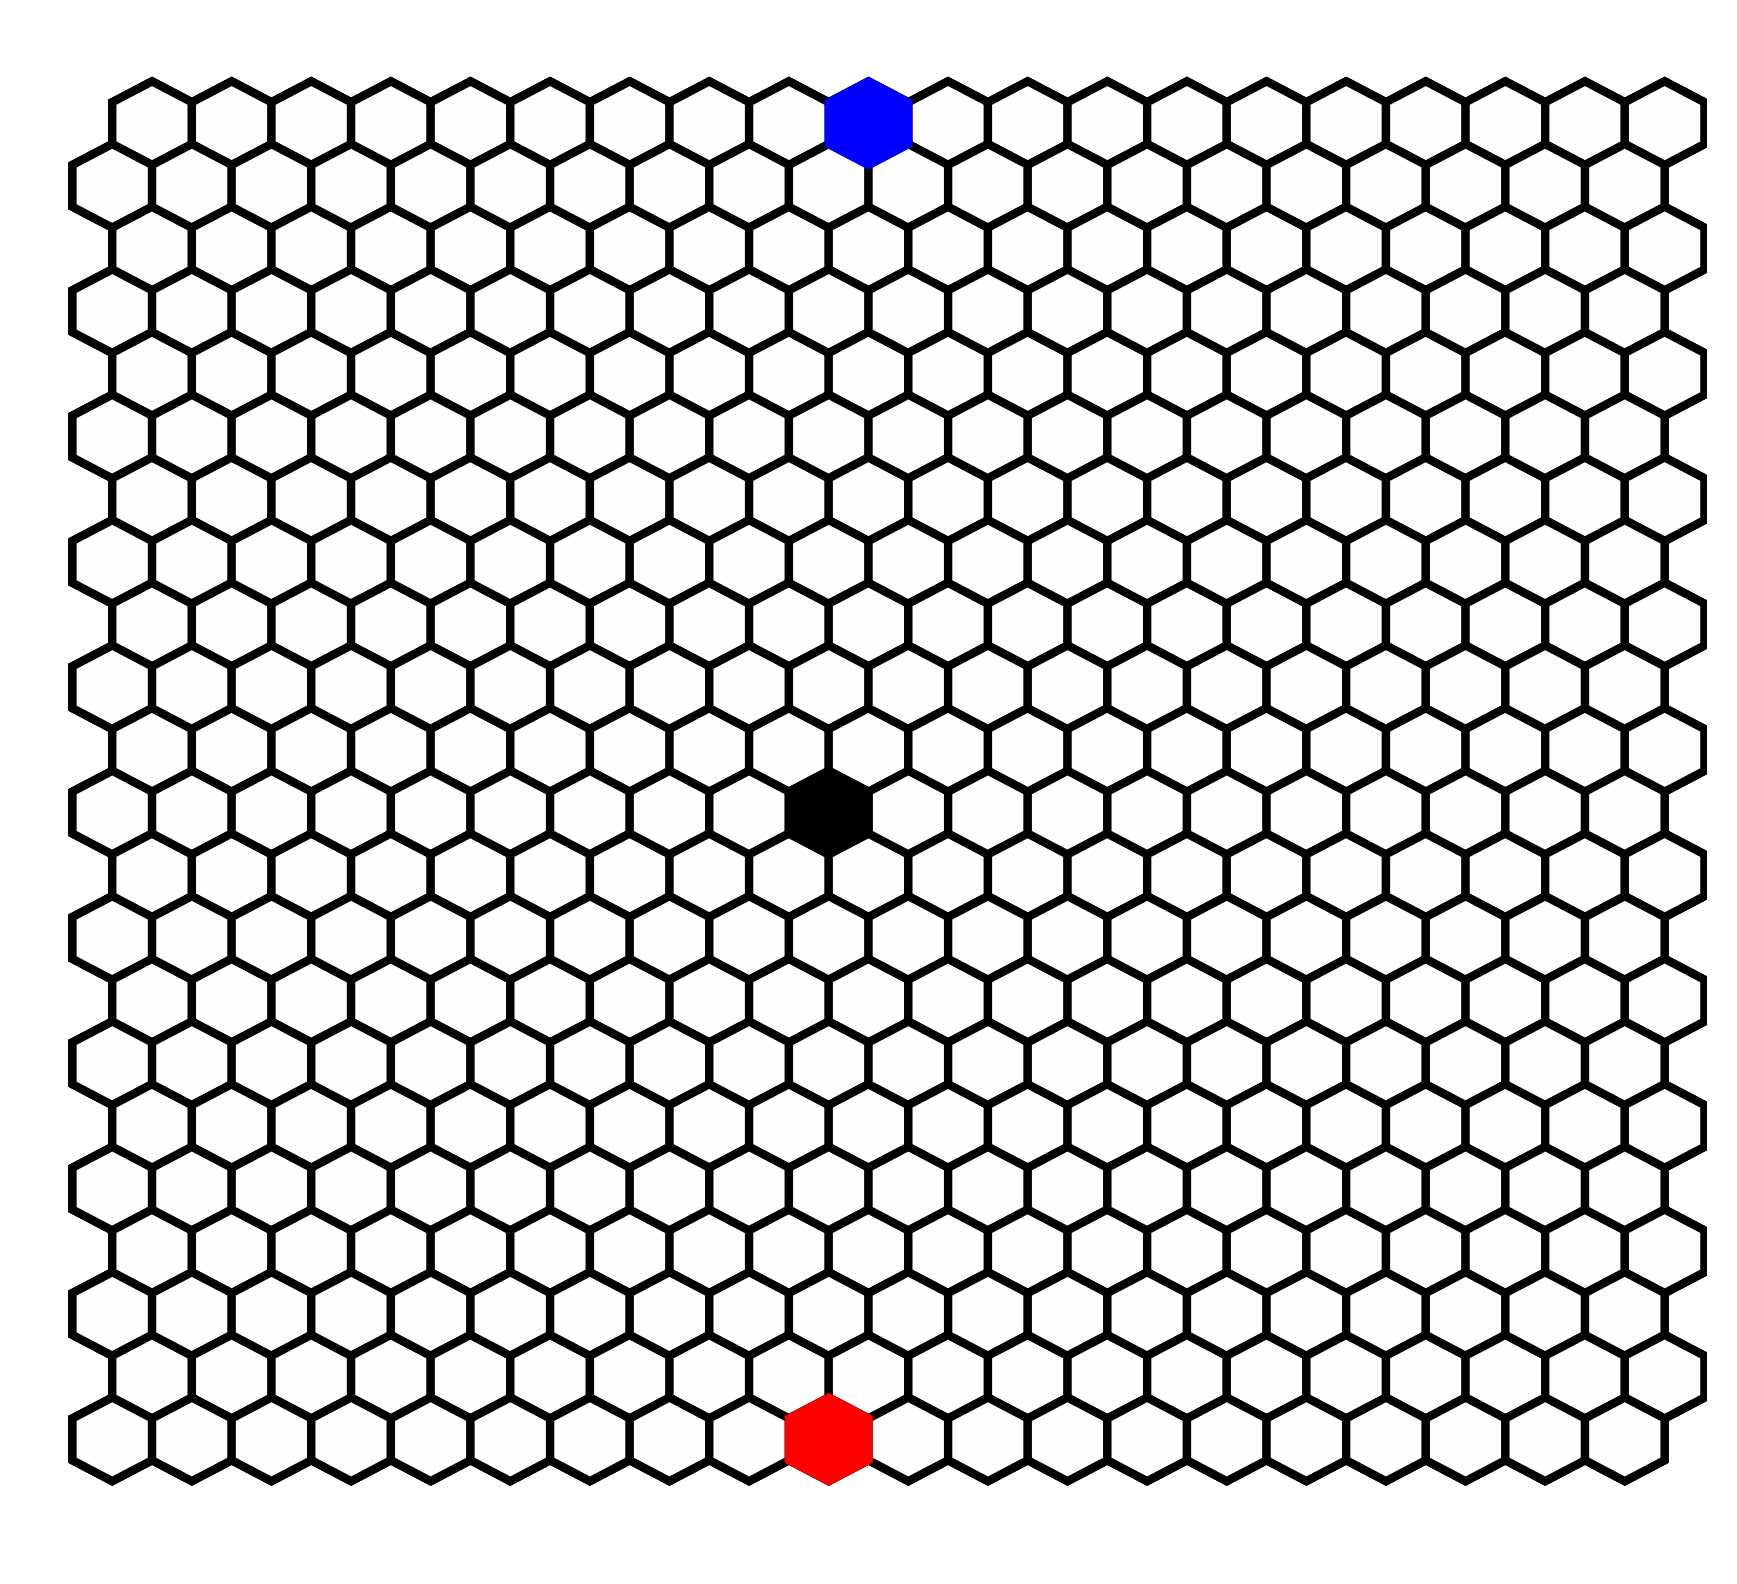

In [18]:
ax = plt.gca()

for pix, c, cmap in zip([220, 210, 199], 
                        ['r', 'k', 'b'],
                        [plt.cm.bwr,
                         plt.cm.Grays,
                         plt.cm.bwr]):
    data = np.zeros(440)
    data[pix-1] = 1 if pix != 199 else -1
    PixelPlot(data, ax=ax, vmin=-1, vmax=1, cmap=cmap,
            markpixels=[pix], markcolor=c)
    
plot.save(plt.gcf(), "nsb_propagation_analysis/camera_example")

In [ ]:
from matplotlib import path as mpath

class OwnErrorMarker(mpath.Path):

    def __init__(self, *args, subtract_mean=True, **kwargs):
        super().__init__(*args, **kwargs)

        if subtract_mean:
            self.vertices = (self.vertices - self.vertices.mean(axis=0))
        self._vertices_orig = self.vertices
        self._scatter_kwargs = dict(facecolors='none',
                                    capstyle='round')

    def reset(self):
        self.vertices = self._vertices_orig

    def top(self, scale=1):
        self.vertices = self._vertices_orig * [scale, scale]
        return self

    def bot(self, scale=1):
        self.vertices = self._vertices_orig * [scale, -scale]
        return self

    def update_scatter_kwargs(self, **scatter_kwargs):
        self._scatter_kwargs.update(**scatter_kwargs)

    def get_scatter_kwargs(self):
        return self._scatter_kwargs

    def add_to_legend(self, ax, label, offset=3, ms=100,
                      rotate=True, scale=1, color='k',
                      do_not_use_label=False):
        loc_vertices = np.concatenate(
            [(self._vertices_orig + [0, offset]) * [scale, scale],
             (self._vertices_orig + [0, offset]) * [scale, -scale]])

        loc_codes = np.concatenate([self.codes, self.codes])

        if rotate:
            loc_vertices = loc_vertices @ [[0, 1], [1, 0]]

        return ax.scatter(np.nan, np.nan, s=ms, edgecolor=color,
                          marker=mpath.Path(loc_vertices, loc_codes),
                          label=None if do_not_use_label else label,
                          **self._scatter_kwargs)


ERROR_MARKERS = {
    "fancy": OwnErrorMarker(
        [[-2, -1], [-1, 1], [1, 1], [2, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO, mpath.Path.LINETO]),
    "rectangle": OwnErrorMarker(
        [[-3, -1], [-3, 1], [3, 1], [3, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO, mpath.Path.LINETO]),
    "triangle": OwnErrorMarker(
        [[-2, -1], [0, 1], [2, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO]),
}

# plotting stuff
def plot_error_markers(ax, x, y, ydown, yup=None, markerstyle='rectangle',
                       scale=1, color='k', **scatter_kwargs):
    #from kapu.extension.markers import ERROR_MARKERS

    om = ERROR_MARKERS[markerstyle]

    scatter_kwargs.update(**om.get_scatter_kwargs())

    if yup is None:
        yup = ydown

    sca1 = ax.scatter(x, y + yup, edgecolors=color,
                      marker=om.top(scale), **scatter_kwargs)
    sca2 = ax.scatter(x, y - ydown, edgecolors=color,
                      marker=om.bot(scale), **scatter_kwargs)

    return (sca1, sca2), om

# legend stuff
def add_errormarker_labels(ax, markers, labels, colors=None,
                           new_legend=False, rotate=True, legend_kwargs={}):

    if colors is None:
        colors = ['k'] * len(markers)

    pcs = []
    for marker, label, color in zip(markers, labels, colors):
        marker = ERROR_MARKERS[marker]
        path_collection = marker.add_to_legend(ax, label, rotate=rotate, color=color,
do_not_use_label=new_legend)
        pcs.append(path_collection)

    if new_legend:
        legend = ax.legend(pcs, labels, **legend_kwargs)
        return legend
    else:
        pass

In [ ]:
from utils.binaries import *
from utils.plotting import *

fig, ax = plt.subplots()

dy = np.abs(np.random.normal(scale=5, size=50))
x = np.linspace(0, 10, 50)
y = x + dy

ax.errorbar(x, y, 0.5*dy, fmt='o', label='hallo')
plot_error_markers(ax, x, y, dy, s=20)


ax.legend()

In [ ]:
from utils.binaries import *
from utils.plotting import *

In [13]:
from iminuit import Minuit
from iminuit.cost import Template
from scipy.optimize import brentq
from frozendict import frozendict
from typing import Tuple
from tqdm import tqdm
import functools

from utils.binaries import *

class FluxStudy():

    # https://journals.aps.org/prd/pdf/10.1103/PhysRevD.57.3873
    FC_CL_95_coefficients = frozendict(**{
        "0.0_1.0": 3.09, "1.0_2.0": 4.14,
        "2.0_3.0": 4.72, "3.0_4.0": 5.25,
        "4.0_5.0": 5.76, "5.0_6.0": 6.26,
        "6.0_7.0": 6.75, "7.0_8.0": 6.81,
        "8.0_9.0": 7.29, "9.0_10.0": 7.77,
        "10.0_11.0": 7.82, "11.0_12.0": 8.29,
        "12.0_13.0": 8.34, "13.0_14.0": 8.80,
        "14.0_15.0": 8.94, "15.0_16.0": 9.31,
    })

    def __init__(self, 
                 photon_efficiency_dict: dict,
                 proton_efficiency_dict : dict,
                 template_dict: dict) -> None:
        
        # T3 trigger efficiencies
        self.photon_efficiency = self._make_2D_piecewise(photon_efficiency_dict)
        self.proton_efficiency = self._make_2D_piecewise(proton_efficiency_dict)

        # Discrimination templates
        # first key: energy, second key: zenith
        self.photon_template = self._make_2D_piecewise(template_dict["photon"])
        self.proton_template = self._make_2D_piecewise(template_dict["proton"])
        self.template_score_bins = template_dict["score_bins"]

        # to cache and speed up calculations we need the available bins
        self.efficiency_energy_bins = self._get_dict_bins(energy_keys := photon_efficiency_dict.keys())
        self.efficiency_theta_bins = self._get_dict_bins(photon_efficiency_dict[list(energy_keys)[0]].keys())
        self.template_energy_bins = self._get_dict_bins(energy_keys := template_dict["photon"].keys())
        self.template_theta_bins = self._get_dict_bins(template_dict["photon"][list(energy_keys)[0]].keys())


    def __call__(self, energies: np.ndarray, zeniths: np.ndarray, method: str,
                 AREA: int = 25, TIME: int = 3) -> dict:
        
        AREA_TIME = AREA * TIME     # in km² yr, please

        match method:
            case "fc":
                return self._calc_upper_lims_feldmann_cousins(energies, zeniths, AREA_TIME)
            case "asimov":
                return self._calc_upper_lims_asimov(energies, zeniths, AREA_TIME)
            case _:
                raise TypeError(f"{method = } not implemented!")


    def _calc_upper_lims_feldmann_cousins(self, 
                                          energies: np.ndarray,
                                          zeniths: np.ndarray,
                                          AREA_TIME: float) -> dict:

            # Step 1: Calculate signal efficiency, bkg contamination that give lowest upper limit
            #      1.1: Calculate exposure for given zenith bins
            partial_exposures = 4 * np.pi * (np.sin(zeniths[1:] * np.pi/360)**2 
                                             - np.sin(zeniths[:-1] * np.pi/360)**2) * AREA_TIME
            partial_exposures = np.append(partial_exposures, 0)
    
            n_background = np.zeros((len(energies), len(zeniths)))
            FC_coeff = self._make_1D_piecewise(self.FC_CL_95_coefficients)
            ratio = np.zeros((len(energies), len(zeniths))) + np.inf
            signal_efficiency = np.zeros_like(ratio)
            FC_coefficients = np.zeros_like(ratio)
            T3_efficiency = np.zeros_like(ratio)

            #      1.2: Calculate expected (background) 6T5 events
            #      1.2: Calculate number of (background) 6T5 events for given energy and zenith bin
            #      1.3: Calculate (and scan) sig eff., bkg. contamination
            #      1.4: Calculate T3 efficiency for photons at energy/zenith
            for i, energy in enumerate(energies):

                energy_bin = np.digitize(energy, self.template_energy_bins) - 1
                template_energy_bin = self.template_energy_bins[energy_bin]

                energy_bin = np.digitize(energy, self.efficiency_energy_bins) - 1
                efficiency_energy_bin = self.efficiency_energy_bins[energy_bin]

                for j, zenith in enumerate(zeniths):

                    
                    zenith_bin = np.digitize(zenith, self.template_theta_bins) - 1
                    template_zenith_bin = self.template_theta_bins[zenith_bin]

                    zenith_bin = np.digitize(zenith, self.template_theta_bins) - 1
                    efficiency_zenith_bin = self.efficiency_theta_bins[zenith_bin]
                    
                    background_flux = self._get_flux()(energy, zenith)

                    sig_template = self.photon_template(template_energy_bin, template_zenith_bin)
                    bkg_template = self.proton_template(template_energy_bin, template_zenith_bin)
                    sig_eff, bkg_contamination = self._calculate_sig_bkg_efficiency(tuple(sig_template.tolist()), 
                                                                                    tuple(bkg_template.tolist()))

                    for sig, bkg in zip(sig_eff, bkg_contamination):
                        # check if we have signal eff. in this bin, if not, ratio = inf
                        if not sig: continue

                        try:
                            n_bkg = bkg * background_flux
                            fc = FC_coeff(n_bkg)
                        except IndexError:
                            fc = np.inf
                                            
                        # update used signal efficiency if ratio lower than best ratio
                        if ratio[i, j] > (new_ratio := fc / sig):
                            signal_efficiency[i, j] = sig
                            FC_coefficients[i, j] = fc
                            n_background[i, j] = n_bkg
                            ratio[i, j] = new_ratio

                        T3_efficiency[i, j] = self.photon_efficiency(efficiency_energy_bin, efficiency_zenith_bin)

            # Step 2: Calculate upper limits
            #      2.2: Calculate upper limits with given exposure
            upper_limit = FC_coefficients / (partial_exposures * T3_efficiency * signal_efficiency)

            return {
                "method": "feldmann_cousins",
                "energy": energies,
                "zenith": zeniths,
                "signal_efficiency": signal_efficiency,
                "upper_limit": upper_limit,
                "FC_coeffs": FC_coefficients,
                "n_background": n_background,
                "exposure": partial_exposures,
                "T3_efficiency": T3_efficiency
            }


    def _calc_upper_lims_asimov(self, 
                                energies,
                                zeniths,
                                AREA_TIME) -> dict:

        # raise NotImplementedError("switch to template arguments")
        
        photon_yield = np.zeros((len(energies), len(zeniths))) + np.inf
        proton_yield = np.zeros((len(energies), len(zeniths)))
        n_background = np.zeros((len(energies), len(zeniths)))

        partial_exposures = 4 * np.pi * (np.sin(zeniths[1:] * np.pi/360)**2 
                                            - np.sin(zeniths[:-1] * np.pi/360)**2) * AREA_TIME
        partial_exposures = np.append(partial_exposures, 0)
    

        @cache
        def _get_template_fit(sig, bkg, mock_data) -> Minuit:
            pass


        # Step 1: Find best photon yield
        for i, energy in tqdm(enumerate(energies)):
            for j, zenith in enumerate(zeniths):

                #  1.1: Template fits for each energy bin
                sig_template = self.photon_template(energy, zenith)
                bkg_template = self.proton_template(energy, zenith)
                background_flux = self._get_flux()(energy, zenith)
                n_background[i][j] = background_flux * partial_exposures[j]

                asimov_data = n_background[i][j] * np.array(bkg_template)


                cost = Template(asimov_data, self.template_score_bins, 
                                (sig_template, bkg_template))
                
                m = Minuit(cost, x0=0.0, x1=asimov_data.sum())
                m.limits["x0", "x1"] = (0, None)
                m.strategy = 2
                m.tol = 1e-6
                m.migrad()
                
                if not m.valid: continue    # don't state upper limit if fit didn't converge
                
                m.hesse()
                m.minos()
                
                if not m.merrors["x0"].upper_valid: continue

                mu_hat = m.values["x0"]
                proton_yield[i] = m.values["x1"]
                sigma  = m.merrors["x0"].upper
                q_min   = cost(mu_hat, proton_yield[i])

                #  1.2: Calculate one-sided 95% C.L. interval
                #       Profile over possible photon yields 
                delta_q_threshold = 2.71

                def _delta_q(mu):
                    m_fix = Minuit(cost, x0=mu, 
                                x1=proton_yield[i])
                    m_fix.fixed["x0"] = True
                    m_fix.limits["x1"] = (0, None)
                    m_fix.migrad()
                    return cost(mu, m_fix.values["x1"]) - q_min

                right_boundary = mu_hat + 3 * sigma
                f_right = _delta_q(right_boundary) - delta_q_threshold

                while f_right < 0:
                    right_boundary *= 2
                    f_right = _delta_q(right_boundary) - delta_q_threshold
                    if right_boundary > 1e6: continue   # don't state upper limit if fit too loose
                
                mu_upper = brentq(lambda mu: _delta_q(mu) - delta_q_threshold, 
                                mu_hat, right_boundary, xtol=1e-3)
                photon_yield[i] = mu_upper

        # Step 2: Calculate upper limits
        #      2.1: T3 efficiency for photons - average over all theta bins
        theta_bins = np.linspace(0, ANGLE, 100, endpoint=False)
        T3 = lambda e: np.mean(np.unique([self.photon_efficiency(e, t) 
                                          for t in theta_bins]))
        
        T3_efficiency = np.zeros_like(energies)
        for i, energy in enumerate(energies):
            T3_efficiency[i] = T3(energy)

        #      2.2: Calculate upper limits with given exposure
        upper_limit = photon_yield / (EXPOSURE * T3_efficiency)

        return {
            "method": "asimov",
            "energy": energies,
            "photon_yield": photon_yield,
            "proton_yield": proton_yield,
            "upper_limit": upper_limit
        }


    @staticmethod
    @functools.cache
    def _calculate_sig_bkg_efficiency(sig_template: Tuple, 
                                      bkg_template: Tuple
                                      ) -> tuple[np.ndarray, np.ndarray]:

        successes = np.array(sig_template)
        trials = np.array(bkg_template)
        trials += successes

        signal_efficiency = np.cumsum(successes) / np.sum(successes)
        contamination = np.cumsum(trials - successes) / np.cumsum(trials)

        return signal_efficiency, contamination


    @functools.cache
    def _get_flux(self) -> callable:
        
        # /cr/users/filip/Projects/PhotonSimulations/MoneyPlot/background/calculate_background.ipynb
        event_flux = {
            '16.5_17': {
                '0_18': 122.56746418758635,
                '18_27': 87.60250325954605,
                '27_33': 33.62112355903881,
                '33_39': 7.119619694827781,
                '39_45': 0.3316566385418091},
            '17_17.5': {
                '0_18': 8163.644005589532,
                '18_27': 7088.826062533549,
                '27_33': 5274.268185136927,
                '33_39': 3232.819738323789,
                '39_45': 1282.7175842002905},
            '17.5_18': {
                '0_18': 4188.464680285597,
                '18_27': 3766.1754318853255,
                '27_33': 3416.023455019529,
                '33_39': 3038.392093665225,
                '39_45': 2390.9363970077975},
            '18_18.5': {
                '0_18': 343.49739479483304,
                '18_27': 320.01646199402694,
                '27_33': 301.71827714415116,
                '33_39': 284.3128433057647,
                '39_45': 260.14909829620547}
        }

        return self._make_2D_piecewise(event_flux)


    @staticmethod
    def _make_1D_piecewise(value_dict) -> callable:

        keys = list(value_dict.keys())
        bins = "_".join(keys)
        bins = np.unique(np.array(bins.split("_")).astype(float))
        index = lambda x: keys[np.digitize(x, bins) - 1]

        @functools.cache
        def _lambda(x: float) -> float:
            return value_dict[index(x)]
        
        return _lambda
    

    @staticmethod
    def _make_2D_piecewise(value_dict) -> callable:

        row_keys = list(value_dict.keys())
        col_keys = list(value_dict[row_keys[0]].keys())

        row_bins = "_".join(row_keys)
        row_bins = np.unique(np.array(row_bins.split("_")).astype(float))
        row_index = lambda x: row_keys[np.digitize(x, row_bins) - 1]

        col_bins = "_".join(col_keys)
        col_bins = np.unique(np.array(col_bins.split("_")).astype(float))
        col_index = lambda x: col_keys[np.digitize(x, col_bins) - 1]

        @functools.cache
        def _lambda(x: float, y: float) -> float:
            return value_dict[row_index(x)][col_index(y)]
        
        return _lambda
    
    
    @staticmethod
    def _get_dict_bins(dict_keys) -> np.ndarray:
        return np.unique([float(x) for k in dict_keys for x in k.split('_')])


In [14]:
from utils.auger.sd.discrimination import Dataset

energies_template = 10**np.arange(16, 18.6, 0.5)
zeniths_template = np.arcsin(np.sqrt(np.linspace(0, np.sin(45 * np.pi/180) ** 2, 6)))
discriminators = tools.pickle_load("/cr/tempdata01/filip/discrimination.pkl")
templates = discriminators.get_templates(energies_template, zeniths_template, score="$M_1$", show=False)


/cr/users/filip/.venv/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [22]:
test = FluxStudy(photon_dict, proton_dict, templates)

In [43]:
max_theta = 45
max_sin = np.sin(max_theta * np.pi/180) ** 2

energies_study = np.log10(0.5 * (10**np.arange(16, 18.5, 0.5) + 10**np.arange(16.5, 18.6, 0.5)))
zeniths_study = np.arcsin(np.sqrt(np.linspace(0, max_sin, 6))) * 180/np.pi
ARENA_TIME = 25 * 3

hallo = _calc_upper_lims_asimov(test, energies_study, zeniths_study, ARENA_TIME)

0it [00:00, ?it/s]

5it [00:00,  7.16it/s]
/tmp/ipykernel_2085177/1570988647.py:113: RuntimeWarning: divide by zero encountered in divide
  upper_limit = upper_photon_yield / (partial_exposures * T3_efficiency)


In [ ]:
from functools import cache
from typing import Union
from numba import njit

def _calc_upper_lims_asimov(self, 
                            energies,
                            zeniths,
                            AREA_TIME) -> dict:

    # raise NotImplementedError("switch to template arguments")
    
    upper_photon_yield = np.zeros((len(energies), len(zeniths))) + np.inf
    proton_yield = np.zeros_like(upper_photon_yield)
    n_background = np.zeros_like(upper_photon_yield)
    T3_efficiency = np.zeros_like(upper_photon_yield)
    partial_exposures = 4 * np.pi * (np.sin(zeniths[1:] * np.pi/360)**2 
                                     - np.sin(zeniths[:-1] * np.pi/360)**2) * AREA_TIME
    partial_exposures = np.append(partial_exposures, 0)

    @cache
    def _get_best_upper_lim(sig_template, 
                            bkg_template,
                            mock_data) -> Union[float, None]:
        
        cost = Template(mock_data, self.template_score_bins, 
                (sig_template, bkg_template))
            
        m = Minuit(cost, x0=0.0, x1=asimov_data.sum())
        m.limits["x0", "x1"] = (0, None)
        m.strategy = 2
        m.tol = 1e-6
        m.migrad()
        
        # don't state upper limit if fit didn't converge
        if not m.valid: return None
        
        m.hesse()
        m.minos()
        
        # don't state upper limit if asymmetric lim invalid
        if not m.merrors["x0"].upper_valid: return None

        mu_hat = m.values["x0"]
        proton_yield[i, j] = m.values["x1"]
        sigma  = m.merrors["x0"].upper
        q_min   = cost(mu_hat, proton_yield[i, j])
        delta_q_threshold = 2.71

        def _delta_q(mu):
            m_fix = Minuit(cost, x0=mu, 
                        x1=proton_yield[i, j])
            m_fix.fixed["x0"] = True
            m_fix.limits["x1"] = (0, None)
            m_fix.migrad()
            return cost(mu, m_fix.values["x1"]) - q_min

        right_boundary = mu_hat + 3 * sigma
        f_right = _delta_q(right_boundary) - delta_q_threshold

        # don't state upper limit if fit too loose
        while f_right < 0:
            right_boundary *= 2
            f_right = _delta_q(right_boundary) - delta_q_threshold
            if right_boundary > 1e6: return None
        
        return brentq(lambda mu: _delta_q(mu) - delta_q_threshold, 
                      mu_hat, right_boundary, xtol=1e-3)


    # Step 1: Find best photon yield
    for i, energy in tqdm(enumerate(energies)):

        energy_bin = np.digitize(energy, self.template_energy_bins) - 1
        template_energy_bin = self.template_energy_bins[energy_bin]

        energy_bin = np.digitize(energy, self.efficiency_energy_bins) - 1
        efficiency_energy_bin = self.efficiency_energy_bins[energy_bin]

        for j, zenith in enumerate(zeniths):

            zenith_bin = np.digitize(zenith, self.template_theta_bins) - 1
            template_zenith_bin = self.template_theta_bins[zenith_bin]

            zenith_bin = np.digitize(zenith, self.template_theta_bins) - 1
            efficiency_zenith_bin = self.efficiency_theta_bins[zenith_bin]

            sig_template = self.photon_template(template_energy_bin, template_zenith_bin)
            bkg_template = self.proton_template(template_energy_bin, template_zenith_bin)

            #  1.1: Template fits for each energy bin, 
            #       find bkg yield at energy/zenith
            background_flux = self._get_flux()(energy, zenith)
            n_background[i, j] = background_flux * partial_exposures[j]

            asimov_data = n_background[i, j] * np.array(bkg_template)

            #  1.2: Calculate one-sided 95% C.L. interval
            #       Profile over possible photon yields
            maybe_result = _get_best_upper_lim(tuple(sig_template.tolist()), 
                                               tuple(bkg_template.tolist()), 
                                               tuple(asimov_data.tolist()))

            if maybe_result is not None:
                upper_photon_yield[i, j] = maybe_result


    # Step 2: Calculate upper limits
    #      2.1: Calculate T3 efficiency for photons at energy/zenith
            T3_efficiency[i, j] = self.photon_efficiency(efficiency_energy_bin, efficiency_zenith_bin)


    #      2.2: Calculate upper limits with given exposure
    upper_limit = upper_photon_yield / (partial_exposures * T3_efficiency)

    return {
        "method": "asimov",
        "energy": energies,
        "zenith": zeniths,
        "upper_photon_yield": upper_photon_yield,
        "proton_yield": proton_yield,
        "upper_limit": upper_limit,
        "n_background": n_background,
        "exposure": partial_exposures,
        "T3_efficiency": T3_efficiency
        
    }

In [4]:
# /cr/users/filip/Projects/PhotonSimulations/detection/03-event-level-detection.ipynb
# 2025-09-22 - normal triggers - photon primary - SPD calculation fixed
photon_dict = {
	'16.0_16.5': {'0_18': 0.00086, '18_26': 0.00012, '26_33': 6e-05, '33_39': 0.0, '39_45': 0.0, },
	'16.5_17.0': {'0_18': 0.24691, '18_26': 0.171, '26_33': 0.11139, '33_39': 0.02252, '39_45': 0.00071, },
	'17.0_17.5': {'0_18': 0.8221, '18_26': 0.81531, '26_33': 0.78832, '33_39': 0.62272, '39_45': 0.25221, },
	'17.5_18.0': {'0_18': 0.9938, '18_26': 0.99567, '26_33': 0.99382, '33_39': 0.98039, '39_45': 0.89109, },
	'18.0_18.5': {'0_18': 1.0, '18_26': 1.0, '26_33': 1.0, '33_39': 1.0, '39_45': 0.99764, },
}
# 2025-09-22 - normal triggers - proton primary - SPD calculation fixed
proton_dict = {
	'16.0_16.5': {'0_18': 0.00822, '18_26': 0.00222, '26_33': 0.00092, '33_39': 9e-05, '39_45': 0.0, },
	'16.5_17.0': {'0_18': 0.39398, '18_26': 0.27208, '26_33': 0.19195, '33_39': 0.06162, '39_45': 0.01145, },
	'17.0_17.5': {'0_18': 0.9391, '18_26': 0.89454, '26_33': 0.83901, '33_39': 0.67107, '39_45': 0.33341, },
	'17.5_18.0': {'0_18': 0.99999, '18_26': 0.99995, '26_33': 0.99976, '33_39': 0.99627, '39_45': 0.94197, },
	'18.0_18.5': {'0_18': 1.0, '18_26': 1.0, '26_33': 1.0, '33_39': 1.0, '39_45': 1.0, },
}

In [34]:
def setup():

    fig, ax = plt.subplots(1, 1)

    axt = ax.twinx()
    ax.set_xlim(3.1623e16, 1.5e20)
    ax.set_ylim(5e-5, 1.1e3)
    axt.set_xlim(3.1623e16, 1.5e20)
    axt.set_ylim(5e-5, 1.1e3)
    axt.set_xscale('log')
    axt.set_yscale('log')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("$E\,/\,\mathrm{eV}$")
    ax.set_ylabel("$J(E)$ / $\mathrm{km}^{-2}\,\mathrm{sr}^{-1}\,\mathrm{yr}^{-1}$")
    axt.set_yticks([])
    axt.set_yticks([])

    axt.set_zorder(0)
    ax.set_zorder(1)

    ax.patch.set_alpha(0.0)

    read = lambda s: np.loadtxt(s, unpack=True)
    theory, data = [], []

    # Theory bands
    # -------------------------------------------------------------------------------
    if True:
        # # (red) GZK Proton I
        # e, f_low, f_high = read("predictions/kampert2011_proton")
        # a = ax.fill_between(np.float_power(10, e), f_low, f_high, alpha=0.5, fc='r', ec='none',
        #                 label="GZK Proton I (Kampert et al. 2011)", zorder=1)
        # theory.append(a)


        # (blue) CR Interactions in Milky Way
        e, f_low, f_high = np.loadtxt("predictions/olivier_milkyway", unpack=True, usecols=[0, 5, 6])
        a = axt.fill_between(e, f_low, f_high, alpha=0.4, fc='b', ec='none',
                        label="Secondary production (Berat et al. 2022)")
        theory.append(a)
    
        # (black) GZK Proton II
        e1, f_low1, f_high1 = read("predictions/range_Frad0")
        e2, f_low2, f_high2 = read("predictions/range_Frad1")

        f_low = np.min([f_low1, f_low2], axis=0)
        f_high = np.max([f_high1, f_high2], axis=0)

        a = axt.fill_between(e1, f_low, f_high, alpha=0.3, fc='#666666', ec='none', zorder=0,
                        label="GZK Protons (Gelmini et al. 2022)")
        theory.append(a)

        # (green) GZK mixed
        e, f_low = read("predictions/Comp1_Histogram.txt")
        e, f_high = read("predictions/Comp2_Histogram.txt")
        a = axt.fill_between(e, f_low, f_high, alpha=0.4, fc='#00cc00', ec='none',
                        label="GZK mixed comp. (Bobrikova et al. 2021)")
        theory.append(a)
    # -------------------------------------------------------------------------------
    
    # Data limits
    # -------------------------------------------------------------------------------
    if True:
        e_sd433 = [5.01e16, 7.94e16, 1.26e17, 2e17]
        j_sd433 = np.array([12.0239, 11.0224, 10.6701, 10.6057])
        l = axt.errorbar(e_sd433, j_sd433, yerr=0.4*j_sd433, uplims=True, c="#999901", 
                        label="Auger SD-433 (2023), 95% C.L.", fmt='o')
        data.append(l)

        e_heco = [2e17, 3e17, 5e17, 1e18]
        j_heco = np.array([2.721, 2.500, 2.741 , 3.547])
        l = axt.errorbar(e_heco, j_heco, yerr=0.4*j_heco, uplims=True, c="red",
                        label="Auger HeCo (2022), 95% C.L.", fmt='o')
        data.append(l)

        e_hybrid = [1e18, 2e18, 3e18, 5e18, 0.97e19]
        j_hybrid = np.array([0.0403, 0.0113, 0.0035, 0.0023, 0.0021])
        l = axt.errorbar(e_hybrid, j_hybrid, yerr=0.4*j_hybrid, uplims=True, c="#3333ff",
                        label="Auger Hybrid (2021), 95% C.L.", fmt='o')
        data.append(l)

        e_sd1500 = [1.01e19, 2e19, 4e19]
        j_sd1500 = np.array([2.11e-3, 0.312e-3, 0.172e-3])
        l = axt.errorbar(e_sd1500, j_sd1500, yerr=0.4*j_sd1500, uplims=True, c="#666666",
                        label="Auger SD-1500 (2023), 95% C.L.", fmt='o')
        data.append(l)

        e_ta2 = [1e18, 10**18.5, 1e19, 10**19.5, 1e20]
        j_ta2 = np.array([0.067, 0.012, 0.0036, 0.0013, 0.0013])
        l = axt.errorbar(e_ta2, j_ta2, yerr=0.4*j_ta2, uplims=True, c="#05cc02",
                        label="Telescope Array (2019), 95% C.L.", fmt='s')
        data.append(l)

        e_ta1 = [1e19, 10**19.5, 1e20]
        j_ta1 = np.array([2e-3, 9.3e-4, 3.9e-4])
        l = axt.errorbar(e_ta1, j_ta1, yerr=0.4*j_ta1, uplims=True, c="#019999",
                        label="Telescope Array (2021), 95% C.L.", fmt='s')
        data.append(l)
    # -------------------------------------------------------------------------------

    leg1 = axt.legend(handles=theory, loc='upper left', fontsize=8.7)
    axt.add_artist(leg1)
    

    leg2 = axt.legend(handles=data, loc='upper right', fontsize=8.7, ncols=1)
    axt.add_artist(leg2)

    return fig, ax

/tmp/ipykernel_2085177/172161632.py:12: RuntimeWarning: Mean of empty slice.
  t3_efficiency = hallo['T3_efficiency'][:, :i].mean(axis=1)


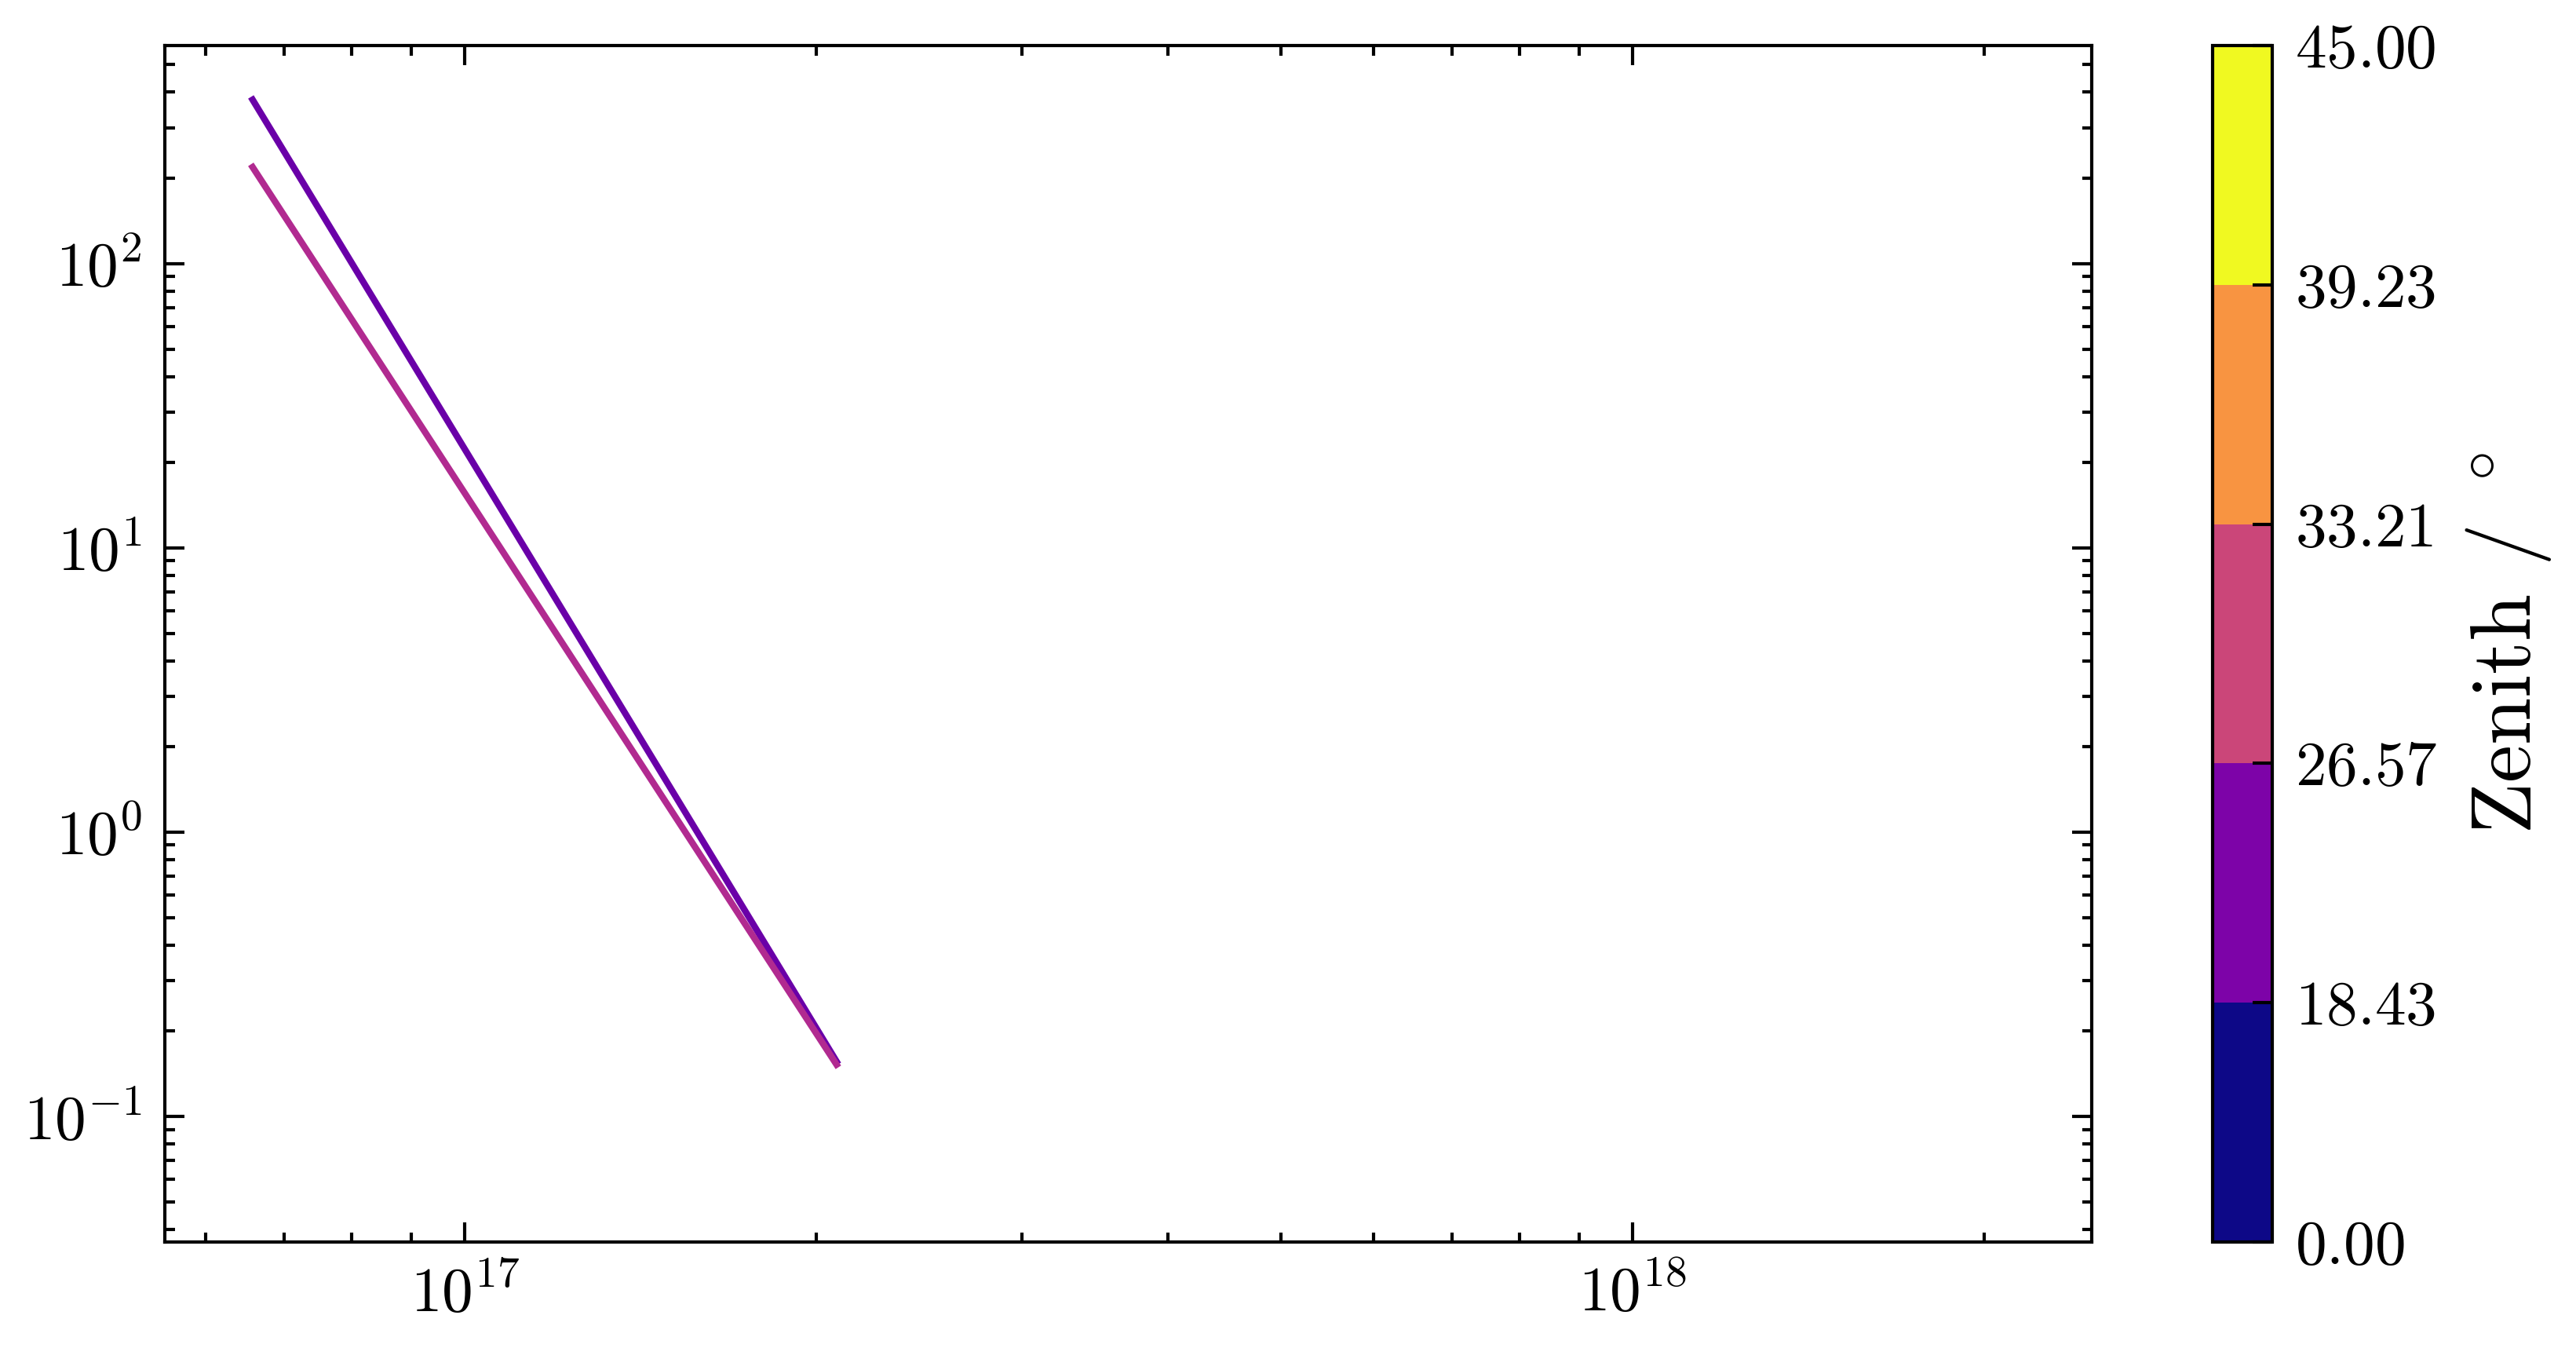

In [44]:
# fig, ax = setup()

# zenith inclusive limits

plasma = plot.gradient(plt.cm.plasma, len(hallo["upper_limit"].T))
e = 10**(hallo["energy"])

for i in range(len(hallo['zenith'])):
    
    upper_limit = hallo['upper_photon_yield'][:, :i].sum(axis=1)
    exposure = hallo['exposure'][:i].sum()
    t3_efficiency = hallo['T3_efficiency'][:, :i].mean(axis=1)

    upper_limit = upper_limit / (exposure * t3_efficiency)

    plt.plot(e, upper_limit, marker='none', c=plasma[i], ls='solid')

cbar = plot.add_colorbar(hallo["zenith"], plt.cm.plasma, plt.gca(), label='Zenith / $^\circ$')
plt.yscale('log')
plt.xscale('log')

In [45]:
hallo

{'method': 'asimov',
 'energy': array([16.31830105, 16.81830105, 17.31830105, 17.81830105, 18.31830105]),
 'zenith': array([ 0.        , 18.43494882, 26.56505118, 33.21091076, 39.23152048,
        45.        ]),
 'upper_photon_yield': array([[           inf,            inf,            inf,            inf,
                    inf,            inf],
        [2.24753539e+03, 1.96220327e+01, 1.96220468e+01, 8.74800567e+00,
         1.72632749e+01, 1.38970970e+00],
        [3.10063914e+00, 3.09608131e+00,            inf,            inf,
         5.51306888e+00, 1.38970970e+00],
        [           inf, 2.40836473e+00,            inf,            inf,
         5.41873316e+00, 1.38970970e+00],
        [1.47245694e+00, 1.42135817e+00, 1.42135817e+00,            inf,
         1.49917734e+00, 1.38970970e+00]]),
 'proton_yield': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [7.97250645e+04, 6.02456937e+04, 6.41443642e+04, 5